# Experiment - Varying number of trees to estimate S@S98


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
import sys
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from joblib import Parallel, delayed
from scipy.integrate import nquad, quad, simps
from scipy.stats import entropy, gamma, multivariate_normal, norm
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize
from sktree.datasets import make_trunk_classification
from sktree.ensemble import HonestForestClassifier
from sktree.stats import FeatureImportanceForestClassifier, build_coleman_forest
from sktree.tree import DecisionTreeClassifier

In [8]:
root_dir = Path("/Users/adam2392/Downloads/outputs/")

N_ESTIMATORS = list(range(100, 4001, 100))
n_repeats = 100

In [9]:
results = defaultdict(list)
for seed in range(n_repeats):
    for n_estimators in N_ESTIMATORS:
        fname = root_dir / f"{seed}_{n_estimators}.npz"
        data = np.load(fname)

        results["sas98"].append(data["sas98"])
        results["idx"].append(data["seed"])
        results["n_estimators"].append(data["n_estimators"])

In [20]:
df = pd.DataFrame(results)

display(df.head())

,sas98,idx,n_estimators
0,0.5791015625,0,100
1,0.765625,0,200
2,0.8193359375,0,300
3,0.8544921875,0,400
4,0.8798828125,0,500


In [24]:
root_dir = Path("/Volumes/Extreme Pro/cancer")
truth_df = pd.DataFrame()

# load the truth values
for sim_name in ["trunk"]:
    if sim_name == "trunk-mix":
        continue
    truth_fname = root_dir / "data" / "truth" / f"{sim_name}.csv"

    truth_df_ = pd.read_csv(truth_fname, header=None)
    truth_df_.columns = ["true_sas98"]
    truth_df_["n_dims"] = [4, 8, 16, 32, 64, 128, 256]
    truth_df_["sim_type"] = sim_name

    truth_df = pd.concat((truth_df, truth_df_), axis=0)

display(truth_df.head())

,true_sas98,n_dims,sim_type
0,0.79438,4,trunk
1,0.89424,8,trunk
2,0.94872,16,trunk
3,0.97768,32,trunk
4,0.98902,64,trunk


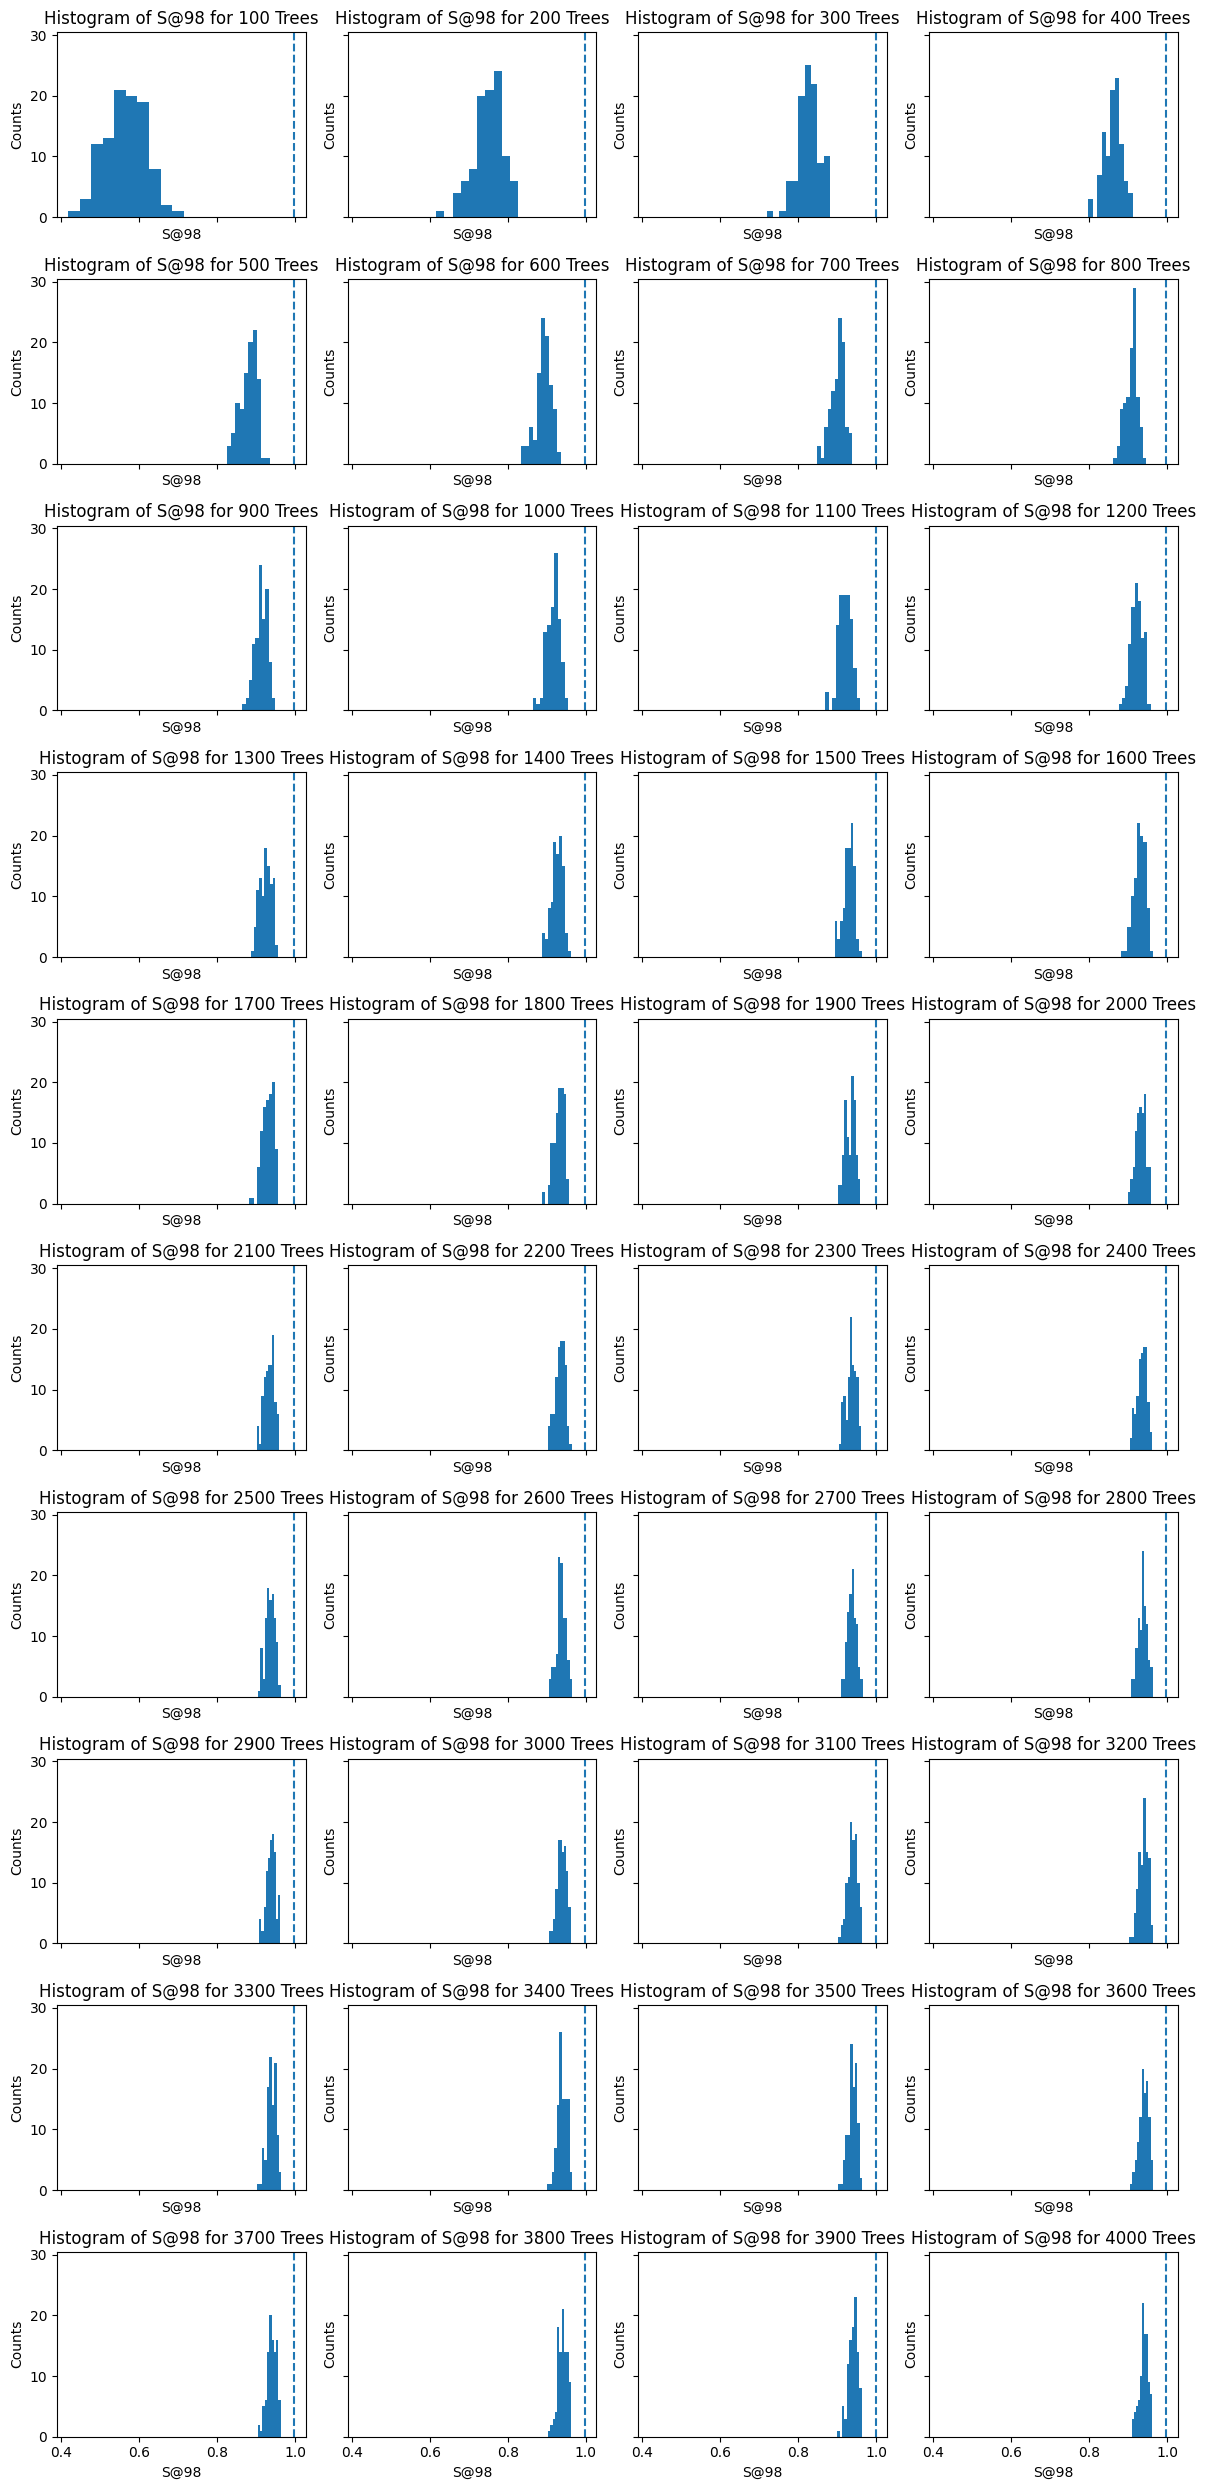

In [29]:
n_rows = len(N_ESTIMATORS) // 4
n_cols = 4
fig, axs = plt.subplots(
    n_rows,
    n_cols,
    figsize=(12, 25),
    sharex=True,
    sharey=True,
)
kdx = 0

truth_val = truth_df[truth_df["sim_type"] == "trunk"]["true_sas98"].max()
for idx in range(n_rows):
    for jdx in range(n_cols):
        ax = axs[idx][jdx]
        n_estimators = N_ESTIMATORS[kdx]

        sas98s = df[df["n_estimators"] == n_estimators]["sas98"]

        ax.hist(sas98s)
        ax.set(
            xlabel="S@98",
            ylabel="Counts",
            title=f"Histogram of S@98 for {n_estimators} Trees",
        )
        ax.axvline([truth_val], ls="--", label="True SAS98")
        kdx += 1

fig.tight_layout()